In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm  
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Custom imports ---
from helpers import load_dataset_paths, compute_average_signal, load_preprocessed_signal
from featex import FeatureExtractor
from CNN_classifier import CNN1D
from preprocessing import preprocess_signal, preprocess_save_all

/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Loading Preprocessed Files

In [2]:
BASE_DIR = "MATLAB_prep/Labelled_VEP_Data"
DEVICES = ["PRIMA", "MP20"]
LABELS = ["BC_Only", "RGC_Only", "BC_and_RGC"]
OUTPUT_DIR = "Preprocessed_VEP_Data"
TMAX = 150
DELAY = 0

all_paths_raw = load_dataset_paths(base_dir=BASE_DIR, devices=DEVICES, labels=LABELS)

prima_files_BC_raw = all_paths_raw["PRIMA"]["BC_Only"]
prima_files_RGC_raw = all_paths_raw["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC_raw = all_paths_raw["PRIMA"]["BC_and_RGC"]
mp20_files_BC_raw = all_paths_raw["MP20"]["BC_Only"]
mp20_files_RGC_raw = all_paths_raw["MP20"]["RGC_Only"]
mp20_files_BC_and_RGC_raw = all_paths_raw["MP20"]["BC_and_RGC"]

preprocess_save_all(BASE_DIR=BASE_DIR, OUTPUT_DIR=OUTPUT_DIR, DEVICES=DEVICES, LABELS=LABELS, normalize=True, tmax=TMAX, delay=DELAY)

Excluded files due to low SNR (<1): 57


In [3]:

all_paths = load_dataset_paths(base_dir=OUTPUT_DIR, devices=DEVICES, labels=LABELS)

# Example usage:

prima_files_BC_only = all_paths["PRIMA"]["BC_Only"]
prima_files_RGC_only = all_paths["PRIMA"]["RGC_Only"]
prima_files_BC_and_RGC = all_paths["PRIMA"]["BC_and_RGC"]

mp20_files_BC_only = all_paths["MP20"]["BC_Only"]
mp20_files_RGC_only = all_paths["MP20"]["RGC_Only"]
mp20_files_BC_and_RGC = all_paths["MP20"]["BC_and_RGC"]

# print how many files are in each category
print(f"PRIMA BC_Only files: {len(prima_files_BC_only)}")
print(f"PRIMA RGC_Only files: {len(prima_files_RGC_only)}")
print(f"PRIMA BC_and_RGC files: {len(prima_files_BC_and_RGC)}")

PRIMA BC_Only files: 110
PRIMA RGC_Only files: 57
PRIMA BC_and_RGC files: 38


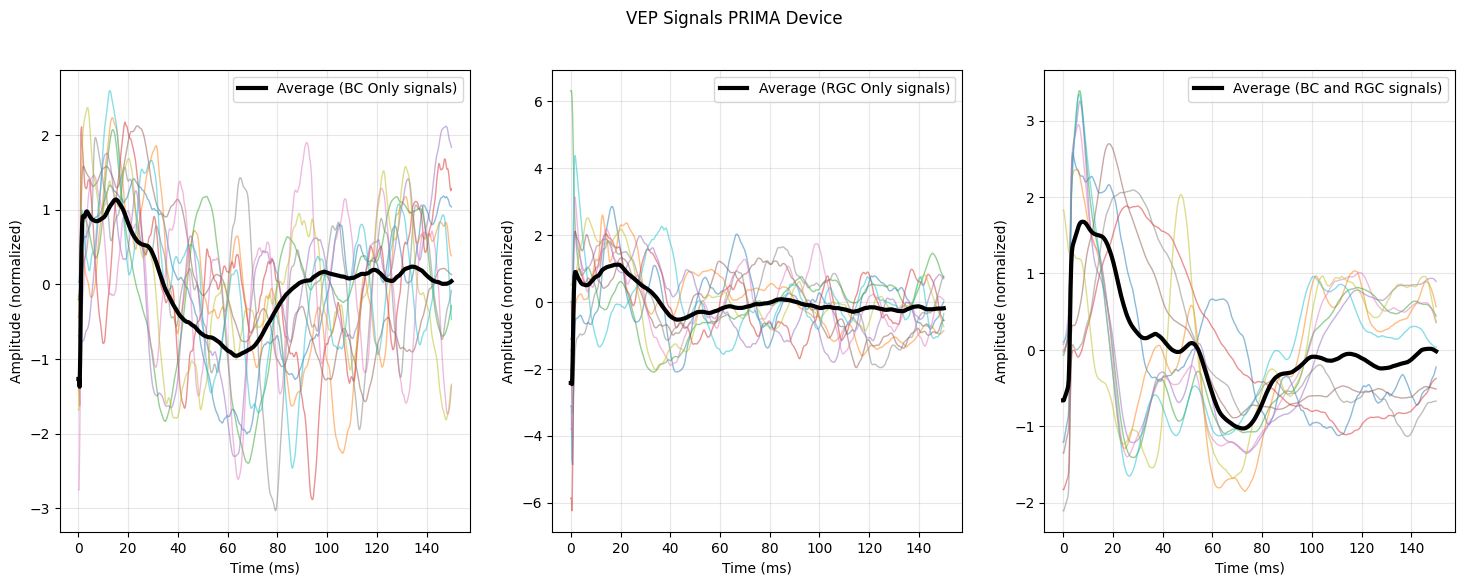

In [4]:
def compute_average_for_files(file_list):
    signals = []
    for file in file_list:
        time, signal = load_preprocessed_signal(file)
        signals.append(signal)
    avg_sig = np.mean(signals, axis=0)
    avg_t = time
    return avg_t, avg_sig

avg_BC_t, avg_BC_sig = compute_average_for_files(prima_files_BC_only)
avg_RGC_t, avg_RGC_sig = compute_average_for_files(prima_files_RGC_only)
avg_BC_RGC_t, avg_BC_RGC_sig = compute_average_for_files(prima_files_BC_and_RGC)

# --- Choose 3 example files per category ---
example_files_BC = prima_files_BC_only[:10]
example_files_RGC = prima_files_RGC_only[:10]
example_files_BC_and_RGC = prima_files_BC_and_RGC[:10]

categories = [
    (example_files_BC, "BC Only", avg_BC_t, avg_BC_sig),
    (example_files_RGC, "RGC Only", avg_RGC_t, avg_RGC_sig),
    (example_files_BC_and_RGC, "BC and RGC", avg_BC_RGC_t, avg_BC_RGC_sig)
]

# --- Plot ---
plt.figure(figsize=(18, 6))
plt.suptitle("VEP Signals PRIMA Device")
for i, (file_list, title, avg_t, avg_sig) in enumerate(categories, 1):
    plt.subplot(1, 3, i)

    # Plot some example signals
    for file in file_list:
        time, signal = load_preprocessed_signal(file)
        plt.plot(time, signal, alpha=0.5, lw=1)

    # Plot the class-wide average in black
    plt.plot(avg_t, avg_sig, color="k", lw=3, label=f"Average ({title} signals)")

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (normalized)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
plt.show()

## 2. DWT feature extraction

In [5]:
# dwt_features, labels = [], []
# for label in ["BC_Only", "RGC_Only", "BC_and_RGC"]:
#     files = prima_files_BC_only if label == "BC_Only" else \
#             prima_files_RGC_only if label == "RGC_Only" else \
#             prima_files_BC_and_RGC

#     for file in tqdm(files, desc=f"Extracting {label}"):
#         _, signal = process_file(file, t_min=10, t_max=200)
#         X_dwt = FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4, max_length=100)
#         dwt_features.append(X_dwt) 
#         labels.append(label)

# # Pad all to equal length (for CNN or ML)
# max_len = max(len(f) for f in dwt_features)
# dwt_features_padded = np.array([np.pad(f, (0, max_len - len(f))) for f in dwt_features])
# labels = np.array(labels)


# unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]

# # --- Plot 1D DWT features per class ---
# plt.figure(figsize=(15, 4))
# for i, label in enumerate(unique_labels, 1):
#     plt.subplot(1, 3, i)
    
#     # Get up to 3 examples from this class
#     class_indices = np.where(labels == label)[0][:3]
    
#     for idx in class_indices:
#         plt.plot(dwt_features_padded[idx], lw=1, alpha=0.8)
    
#     plt.title(f"{label}")
#     plt.xlabel("Coefficient Index")
#     plt.ylabel("Amplitude")
#     plt.grid(alpha=0.3)

# plt.suptitle("1D DWT Features per Class", fontsize=14)
# plt.tight_layout()
# plt.show()


## 2. DWT downsampling

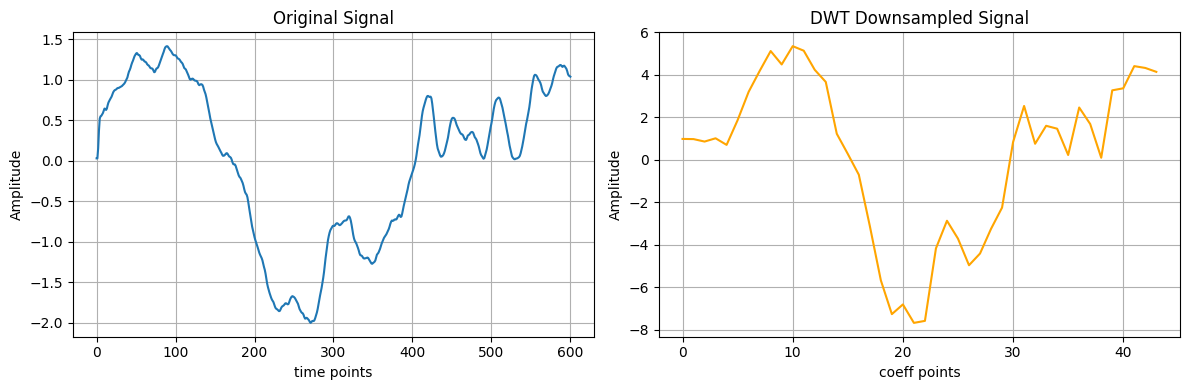

In [6]:
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
example_file = prima_files_BC_only[0]
time, signal = load_preprocessed_signal(example_file)

downsampled_signal = FeatureExtractor.dwt_downsampling(signal, wavelet='db4', level=4)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('time points')
plt.ylabel('Amplitude')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(downsampled_signal, label='DWT Downsampled Signal', color='orange')
plt.title('DWT Downsampled Signal')
plt.xlabel('coeff points')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()

## Classification


=== Processing Signal Type: DWT ===
--- Experiment 1 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 31, val_loss=0.2958, val_acc=0.8696, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 47 → best epoch = 27, val_loss=0.3619, val_acc=0.8261, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 27 → best epoch = 7, val_loss=0.6033, val_acc=0.6957, train_acc=0.8791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 38 → best epoch = 18, val_loss=0.3909, val_acc=0.8696, train_acc=0.9451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 45 → best epoch = 25, val_loss=0.1119, val_acc=0.9545, train_acc=0.9891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


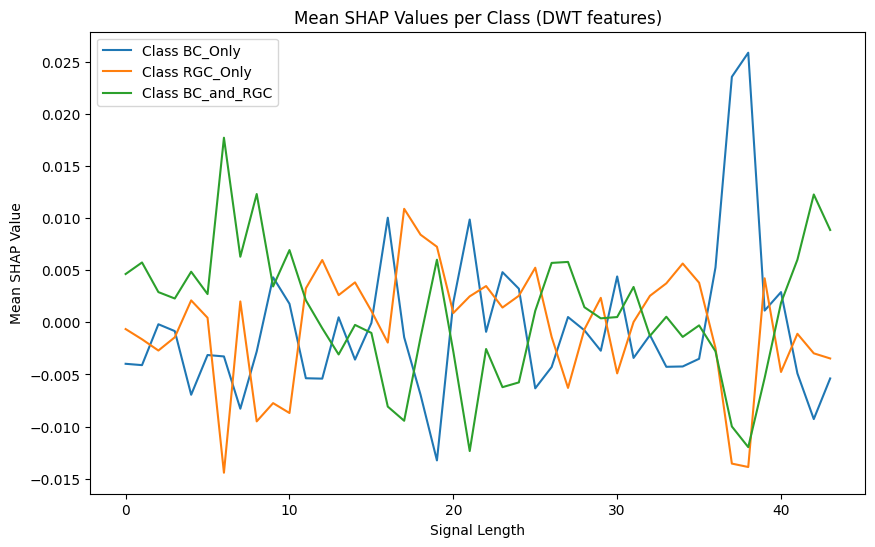

[[29  6  3]
 [ 4 33  1]
 [ 2  2 34]]
--- Experiment 2 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 50, val_loss=0.2665, val_acc=0.9565, train_acc=0.9890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 46, val_loss=0.2317, val_acc=0.9130, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 30 → best epoch = 10, val_loss=0.5933, val_acc=0.6957, train_acc=0.9341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 44 → best epoch = 24, val_loss=0.3198, val_acc=0.9130, train_acc=0.9670
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 41 → best epoch = 21, val_loss=0.1956, val_acc=1.0000, train_acc=0.9891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


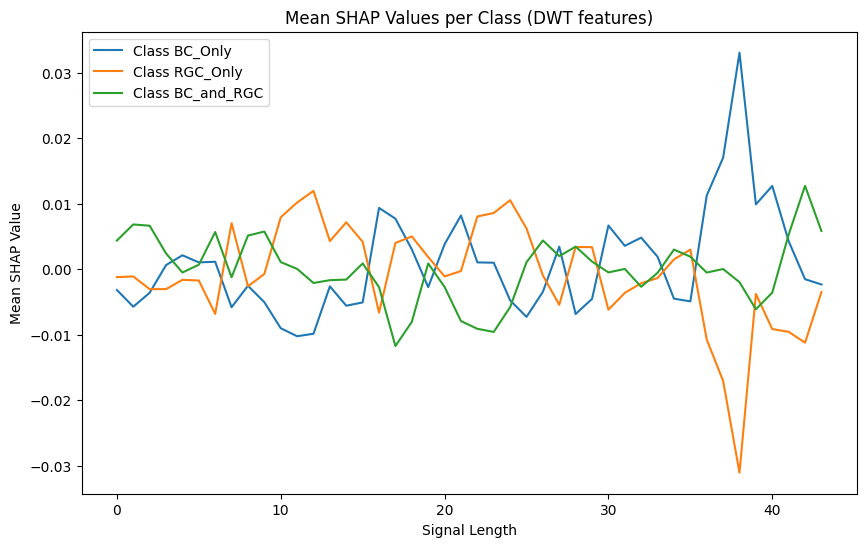

[[34  3  1]
 [ 4 33  1]
 [ 3  0 35]]
--- Experiment 3 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 42 → best epoch = 22, val_loss=0.3866, val_acc=0.8696, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 30, val_loss=0.2260, val_acc=0.8696, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 28 → best epoch = 8, val_loss=0.5902, val_acc=0.6957, train_acc=0.9121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 32 → best epoch = 12, val_loss=0.3781, val_acc=0.9130, train_acc=0.9011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 41 → best epoch = 21, val_loss=0.1481, val_acc=0.9545, train_acc=0.9891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


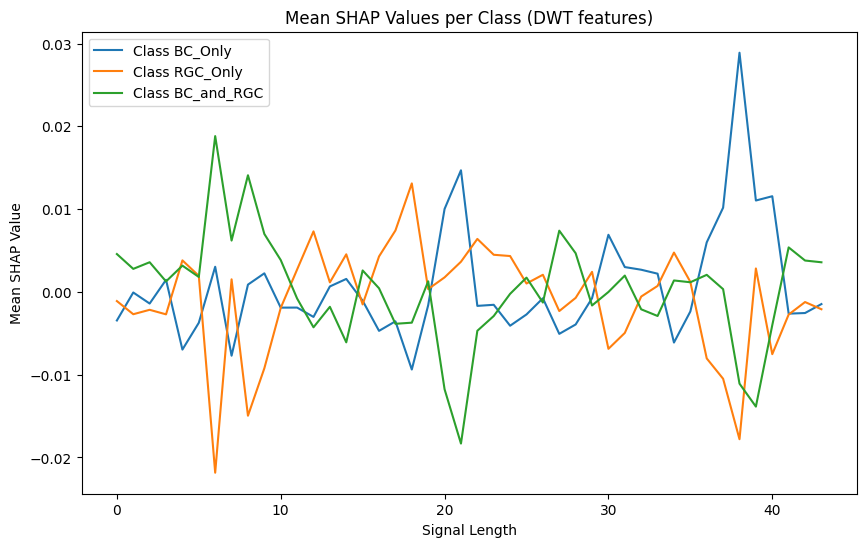

[[31  5  2]
 [ 5 32  1]
 [ 2  1 35]]
--- Experiment 4 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 41 → best epoch = 21, val_loss=0.3960, val_acc=0.7391, train_acc=0.9560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 46 → best epoch = 26, val_loss=0.2942, val_acc=0.8696, train_acc=0.9890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 27 → best epoch = 7, val_loss=0.6972, val_acc=0.6957, train_acc=0.8462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 31 → best epoch = 11, val_loss=0.3890, val_acc=0.8261, train_acc=0.9011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 48 → best epoch = 28, val_loss=0.1385, val_acc=0.9545, train_acc=0.9891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


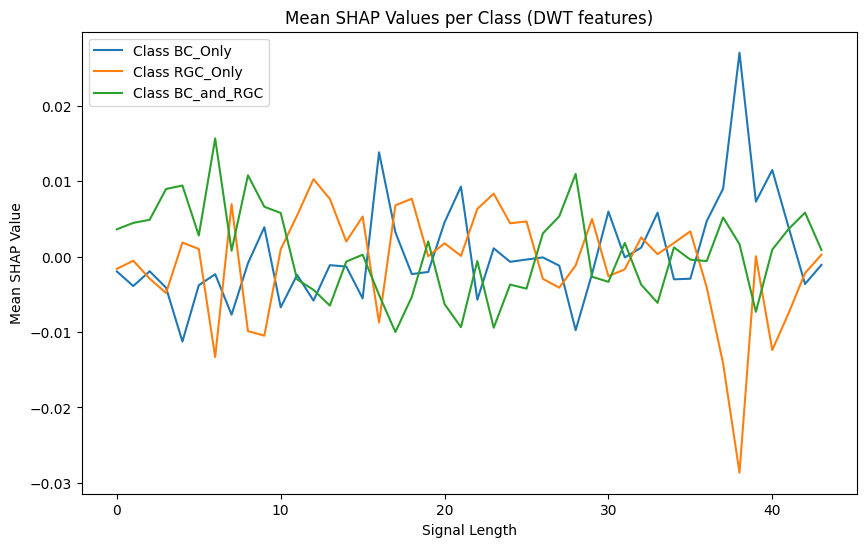

[[28  7  3]
 [ 5 31  2]
 [ 4  0 34]]
--- Experiment 5 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 36, val_loss=0.3770, val_acc=0.8261, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 50, val_loss=0.1596, val_acc=0.9130, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 32 → best epoch = 12, val_loss=0.7191, val_acc=0.6957, train_acc=0.9560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 32 → best epoch = 12, val_loss=0.3833, val_acc=0.8261, train_acc=0.9011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 39 → best epoch = 19, val_loss=0.1869, val_acc=1.0000, train_acc=0.9348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


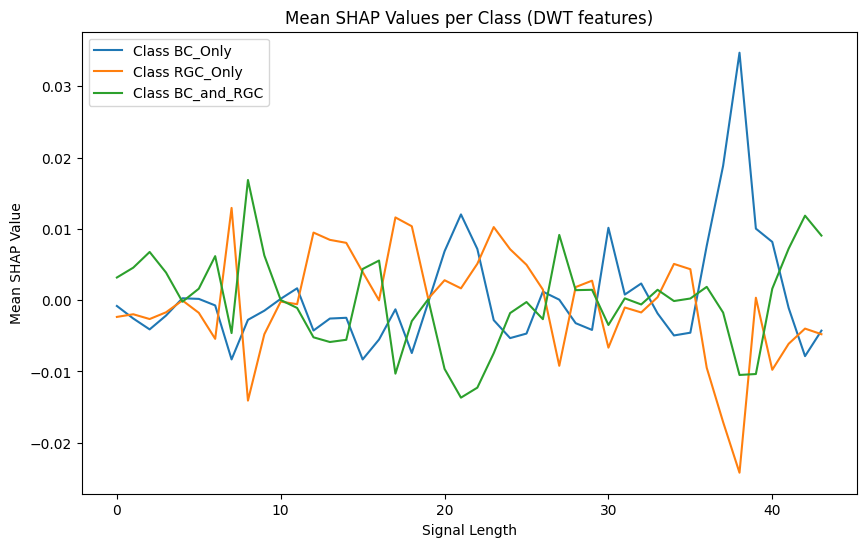

[[31  5  2]
 [ 6 31  1]
 [ 3  0 35]]
--- Experiment 6 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 41, val_loss=0.2066, val_acc=0.9565, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 34, val_loss=0.2576, val_acc=0.8696, train_acc=0.9890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 29 → best epoch = 9, val_loss=0.5502, val_acc=0.7391, train_acc=0.9011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 36 → best epoch = 16, val_loss=0.2924, val_acc=0.9130, train_acc=0.9451
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 46 → best epoch = 26, val_loss=0.1581, val_acc=0.9545, train_acc=0.9891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


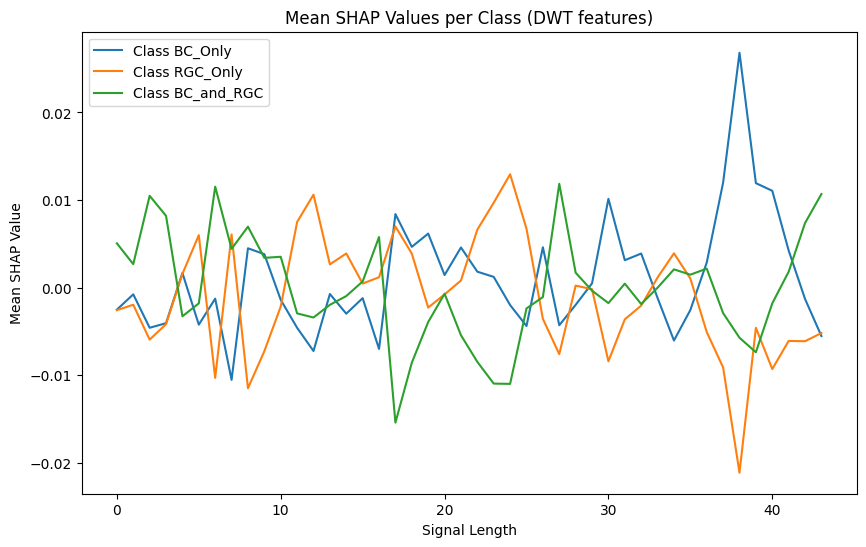

[[32  5  1]
 [ 4 33  1]
 [ 2  0 36]]
--- Experiment 7 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 48, val_loss=0.1991, val_acc=0.9130, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 39 → best epoch = 19, val_loss=0.2821, val_acc=0.8696, train_acc=0.9560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 27 → best epoch = 7, val_loss=0.5756, val_acc=0.6957, train_acc=0.8901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 30 → best epoch = 10, val_loss=0.3738, val_acc=0.9130, train_acc=0.8681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 39 → best epoch = 19, val_loss=0.1998, val_acc=0.9091, train_acc=0.9674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


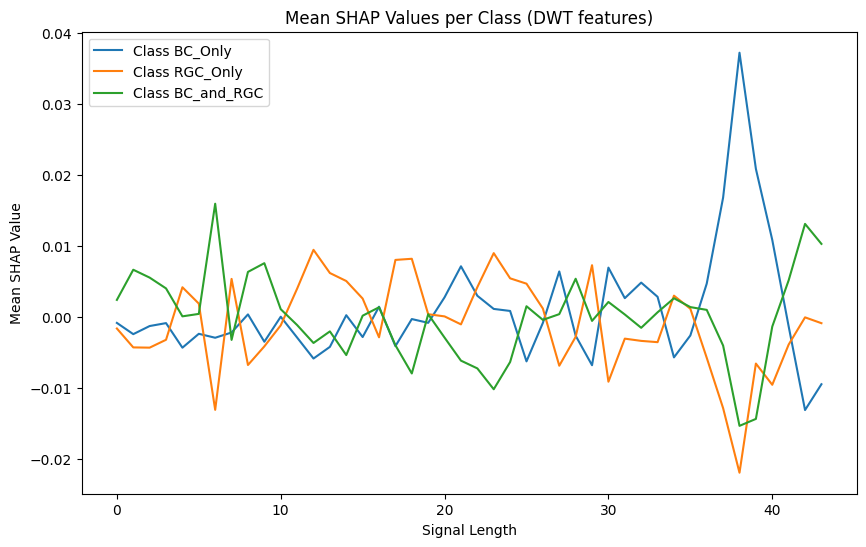

[[32  4  2]
 [ 5 32  1]
 [ 3  1 34]]
--- Experiment 8 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 38, val_loss=0.2671, val_acc=0.9130, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 42, val_loss=0.2483, val_acc=0.8696, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 29 → best epoch = 9, val_loss=0.6860, val_acc=0.6957, train_acc=0.9011
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 36 → best epoch = 16, val_loss=0.2915, val_acc=0.8261, train_acc=0.9560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 33 → best epoch = 13, val_loss=0.2494, val_acc=0.9545, train_acc=0.8913
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


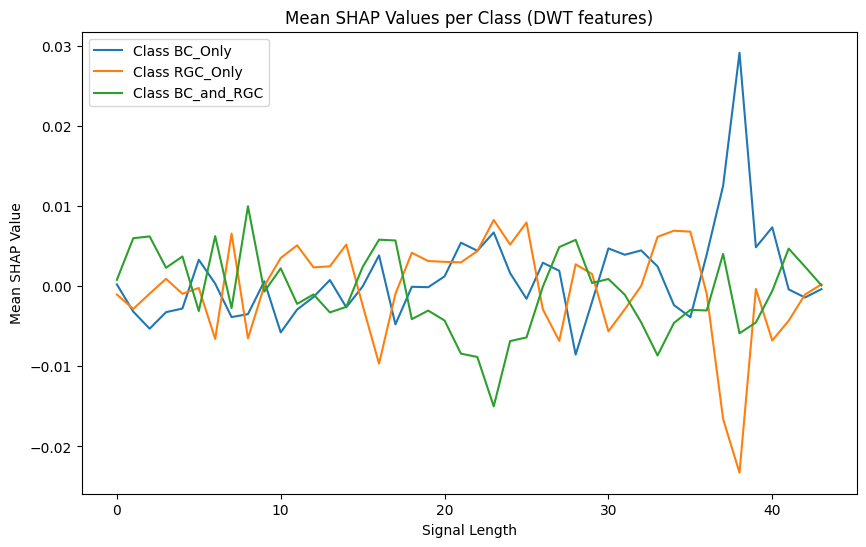

[[30  5  3]
 [ 4 33  1]
 [ 2  2 34]]
--- Experiment 9 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 50 → best epoch = 36, val_loss=0.3033, val_acc=0.9130, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 31, val_loss=0.3102, val_acc=0.8261, train_acc=0.9890
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 33 → best epoch = 13, val_loss=0.6326, val_acc=0.7391, train_acc=0.9231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 38 → best epoch = 18, val_loss=0.4570, val_acc=0.8261, train_acc=0.9560
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 41 → best epoch = 21, val_loss=0.1486, val_acc=1.0000, train_acc=0.9674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


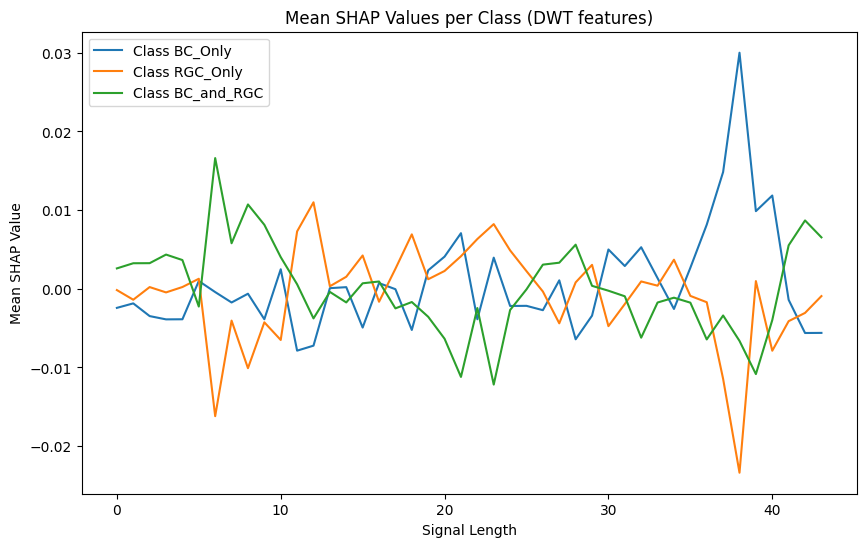

[[31  4  3]
 [ 6 31  1]
 [ 2  0 36]]
--- Experiment 10 ---
Number of training samples: 114
Using batch size: 11
Using epochs: 50
[Fold 1] Early stopped at epoch 46 → best epoch = 26, val_loss=0.2504, val_acc=0.9565, train_acc=0.9780
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 2] Early stopped at epoch 50 → best epoch = 33, val_loss=0.3108, val_acc=0.8696, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 3] Early stopped at epoch 28 → best epoch = 8, val_loss=0.6532, val_acc=0.6957, train_acc=0.8791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 4] Early stopped at epoch 33 → best epoch = 13, val_loss=0.3830, val_acc=0.7826, train_acc=0.9341
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(23, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


[Fold 5] Early stopped at epoch 50 → best epoch = 34, val_loss=0.1275, val_acc=0.9545, train_acc=1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(22, 44, 1))']
  warnings.warn(msg)
/Users/lillikiessling/Documents/Stanford/Code/VEP_Classifier/.venv/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 44, 1))']
  warnings.warn(msg)


shap_results_shapes: (22, 44, 1, 3)
mean_shap shape: (44,)
mean_shap shape: (44,)
mean_shap shape: (44,)


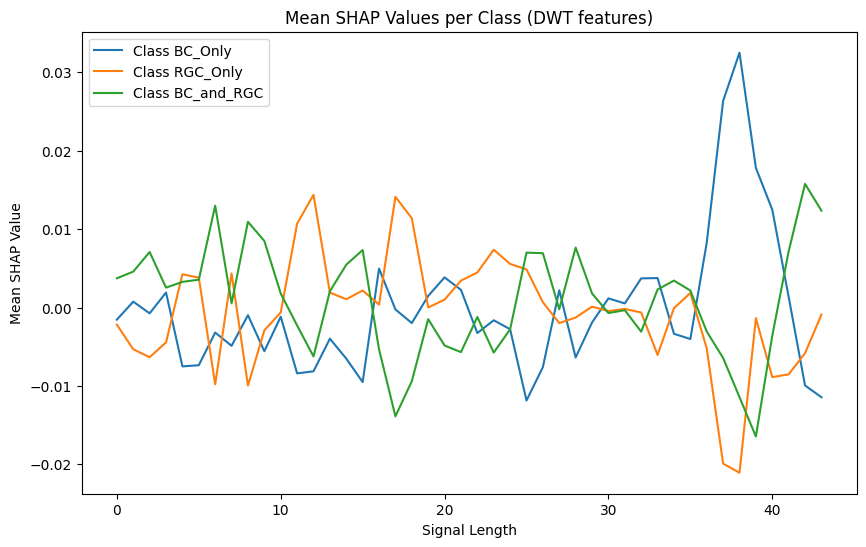

[[31  5  2]
 [ 5 31  2]
 [ 2  1 35]]


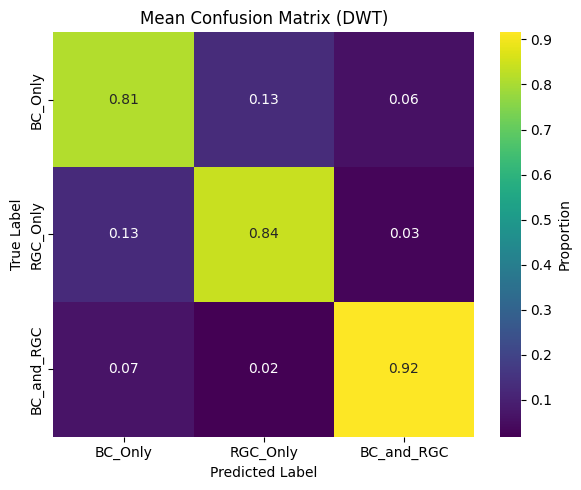

In [7]:
average_results = {}

signal_types = ["DWT"]

for signal_type in signal_types:
    print(f"\n=== Processing Signal Type: {signal_type} ===")
    results = []
    all_conf_matrices = []
    for experiments in range(10):
        print(f"--- Experiment {experiments + 1} ---")
        np.random.seed(42)
        no_files = min(len(prima_files_BC_only), len(prima_files_RGC_only), len(prima_files_BC_and_RGC))
        sampled_BC = np.random.choice(prima_files_BC_only, no_files, replace=False)
        sampled_RGC = np.random.choice(prima_files_RGC_only, no_files, replace=False)
        sampled_BC_and_RGC = np.random.choice(prima_files_BC_and_RGC, no_files, replace=False)

        X, labels = [], []
        for file in sampled_BC:
            _, signal = load_preprocessed_signal(file)
            if signal_type == "Raw":
                X.append(signal)
            else:
                #X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
                X.append(FeatureExtractor.dwt_downsampling(signal, wavelet='db4', level=4))
            labels.append("BC_Only")
        for file in sampled_RGC:
            _, signal = load_preprocessed_signal(file)
            if signal_type == "Raw":
                X.append(signal)
            else:
                #X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
                X.append(FeatureExtractor.dwt_downsampling(signal, wavelet='db4', level=4))
            labels.append("RGC_Only")
        for file in sampled_BC_and_RGC:
            _, signal = load_preprocessed_signal(file)
            if signal_type == "Raw":
                X.append(signal)
            else:
                #X.append(FeatureExtractor.extract_dwt_features(signal, wavelet='db4', level=4))
                X.append(FeatureExtractor.dwt_downsampling(signal, wavelet='db4', level=4))
            labels.append("BC_and_RGC")

        n_train = len(X)
        print(f"Number of training samples: {n_train}")
        epochs = 50
        batch_size = max(4, min(32, n_train // 10))

        print(f"Using batch size: {batch_size}")
        print(f"Using epochs: {epochs}")

        clf = CNN1D(X, labels, model_type="cnn", n_splits=5, random_state=42)
        y_true, y_pred, shap_values = clf.fit(epochs=epochs, batch_size=batch_size)
        print("shap_results_shapes:", shap_values.shape) # (17, 761, 1, 3) = (n_samples, signal_length, 1, n_classes)
        plt.figure(figsize=(10, 6))
        for c in range(shap_values.shape[-1]):
            mean_shap = np.mean(shap_values[:, :, 0, c], axis=0)  # Mean SHAP values for class c
            print("mean_shap shape:", mean_shap.shape)  # (signal_length,)
            plt.plot(mean_shap, label=f"Class {unique_labels[c]}")
        plt.title(f"Mean SHAP Values per Class ({signal_type} features)")
        plt.xlabel("Signal Length")
        plt.ylabel("Mean SHAP Value")
        plt.legend()
        plt.show()
        metrics = clf.evaluate(y_true, y_pred)

        results.append({
                "Accuracy": metrics["accuracy"],
                "BalancedAcc": metrics["balanced_accuracy"],
                "F1": metrics["f1_score"],
                "Acc BC_Only": metrics["report"]["BC_Only"]["recall"],
                "Acc RGC_and_BC": metrics["report"]["BC_and_RGC"]["recall"],
                "Acc RGC_Only": metrics["report"]["RGC_Only"]["recall"],
            })
        all_conf_matrices.append(
            confusion_matrix(
                y_true, y_pred, labels=["BC_Only", "RGC_Only", "BC_and_RGC"]
            )
        )

    accs = [r["Accuracy"] for r in results]
    balanced_accs = [r["BalancedAcc"] for r in results]
    f1s = [r["F1"] for r in results]
    bc_accs = [float(r["Acc BC_Only"]) for r in results]
    rgc_accs = [float(r["Acc RGC_Only"]) for r in results]
    bc_rgc_accs = [float(r["Acc RGC_and_BC"]) for r in results]

    average_results[(signal_type)] = {
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "BalancedAcc_mean": np.mean(balanced_accs),
        "BalancedAcc_std": np.std(balanced_accs),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),

        # per-class accuracies (recall)
        "Acc_BC_Only_mean": np.mean(bc_accs),
        "Acc_BC_Only_std": np.std(bc_accs),
        "Acc_RGC_Only_mean": np.mean(rgc_accs),
        "Acc_RGC_Only_std": np.std(rgc_accs),
        "Acc_BC_and_RGC_mean": np.mean(bc_rgc_accs),
        "Acc_BC_and_RGC_std": np.std(bc_rgc_accs),
    }
    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    mean_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)

    labels = ["BC_Only", "RGC_Only", "BC_and_RGC"] 
    plt.figure(figsize=(6,5)) 
    sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", cmap="viridis", xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Proportion'}) 
    plt.title(f"Mean Confusion Matrix ({signal_type})") 
    plt.xlabel("Predicted Label") 
    plt.ylabel("True Label") 
    plt.tight_layout()
    plt.show()

In [11]:
for signal_type, metrics in average_results.items():
    print(f"\n=== Average Results for Signal Type: {signal_type} ===")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


=== Average Results for Signal Type: DWT ===
Accuracy_mean: 0.8570
Accuracy_std: 0.0208
BalancedAcc_mean: 0.8570
BalancedAcc_std: 0.0208
F1_mean: 0.8569
F1_std: 0.0211
Acc_BC_Only_mean: 0.8132
Acc_BC_Only_std: 0.0415
Acc_RGC_Only_mean: 0.8421
Acc_RGC_Only_std: 0.0235
Acc_BC_and_RGC_mean: 0.9158
Acc_BC_and_RGC_std: 0.0197


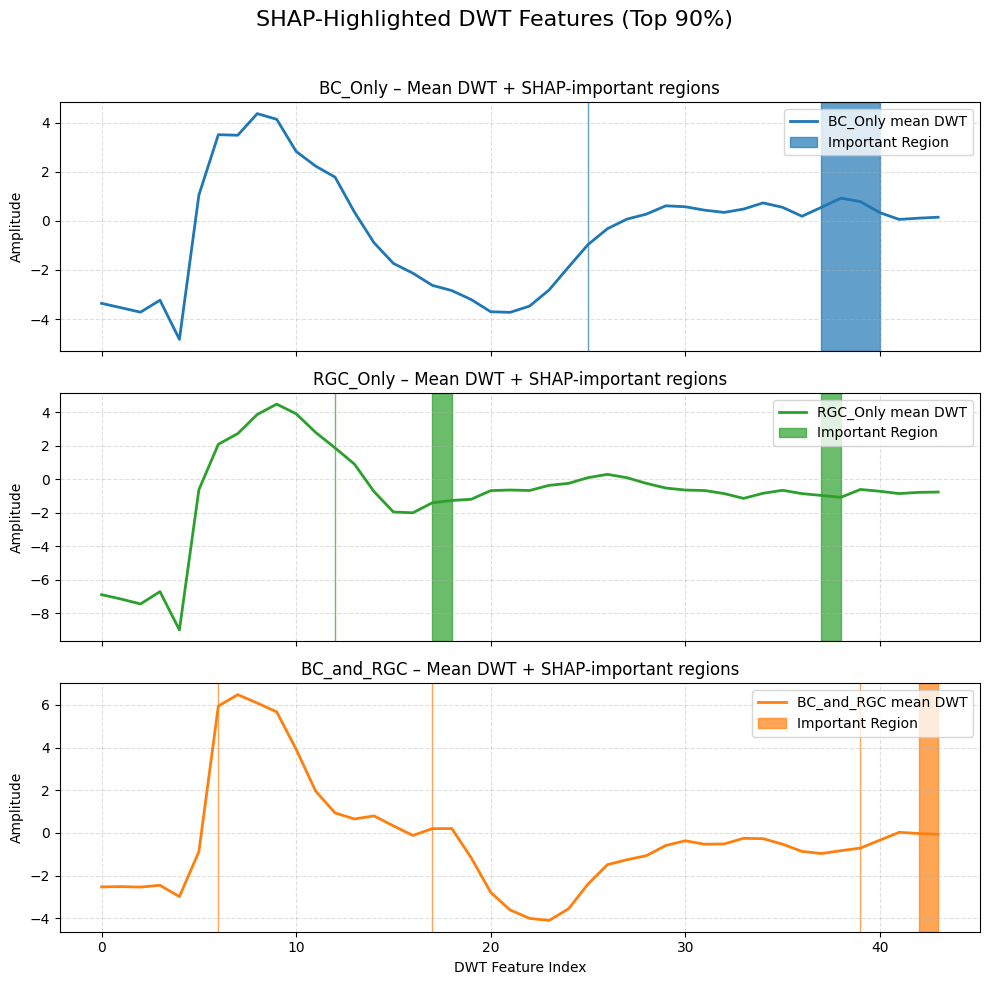

In [16]:
ABS_SHAP_THRESHOLD_PERCENTILE = 90
unique_labels = ["BC_Only", "RGC_Only", "BC_and_RGC"]
label_colors = ['tab:blue', 'tab:green', 'tab:orange']

# Calculate the overall average signal for each class for visualization
mean_dwt = {}
mean_dwt["BC_Only"] = FeatureExtractor.dwt_downsampling(avg_BC_sig, wavelet='db4', level=4)
mean_dwt["RGC_Only"] = FeatureExtractor.dwt_downsampling(avg_RGC_sig, wavelet='db4', level=4)
mean_dwt["BC_and_RGC"] = FeatureExtractor.dwt_downsampling(avg_BC_RGC_sig, wavelet='db4', level=4)


fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

for idx, class_label in enumerate(unique_labels):
    ax = axes[idx]

    # --- SHAP extraction for this class ---
    c = idx
    mean_shap = np.mean(shap_values[:, :, 0, c], axis=0)
    abs_mean_shap = np.abs(mean_shap)

    # threshold for "important" SHAP positions
    threshold = np.percentile(abs_mean_shap, ABS_SHAP_THRESHOLD_PERCENTILE)
    important_indices = np.where(abs_mean_shap >= threshold)[0]

    # --- Plot the mean DWT signal ---
    ax.plot(
        mean_dwt[class_label], 
        color=label_colors[idx], 
        linewidth=2,
        label=f"{class_label} mean DWT"
    )

    # --- Group continuous important regions ---
    segments = []
    if len(important_indices) > 0:
        start = important_indices[0]
        end = important_indices[0]
        for i in range(1, len(important_indices)):
            if important_indices[i] == important_indices[i-1] + 1:
                end = important_indices[i]
            else:
                segments.append((start, end))
                start = important_indices[i]
                end = important_indices[i]
        segments.append((start, end))  # append last segment

    # --- Highlight segments ---
    for j, (start, end) in enumerate(segments):
        ax.axvspan(start, end, 
                   alpha=0.7, 
                   color=label_colors[idx],
                   label="Important Region" if j == 0 else None)

    # --- Titles and styling ---
    ax.set_title(f"{class_label} – Mean DWT + SHAP-important regions")
    ax.set_ylabel("Amplitude")
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='upper right')

axes[-1].set_xlabel("DWT Feature Index")

plt.suptitle(f"SHAP-Highlighted DWT Features (Top {ABS_SHAP_THRESHOLD_PERCENTILE}%)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()